<table style="width: 100%">
<tr>
    <td style="width: 20%; text-align: left">

    
<h1>Sorbonne Université - ISUP</h1> <br>
<h2>Master Ingénierie Mathématiques </h2> <br>
<h3>Parcours Ingénierie Statistique et Data Science (ISDS)</h3>
 <h3> Année universitaire 2020-2021</h3>
        <br>
    </td>
    <td style="width:20%; text-align: left">
<table>           

# But du projet

### Prédire la probabilité q'un client va demander la résiliation de son abonnement téléphonique dans un mois, dans le but  d'effectuer une campagne de retention.

## Problematique:

1) Est-il vraiment nécessaire de tenter de fideliser tous les clients qui veulent partir? La reponse est Non car les clients qui ne sont pas rentable pour l'entreprise, leur départ serait bénéfique.


2) Plus la probabilité qu'un client parte est élévé plus il serait difficile de le retenir.


3) Notre base de donnée manque d'information: On ne sait pas si la résiliation de l'abonnement du client a été entrepris par le client lui même ou par l'entreprise  pour une raison quelconque (ex facture impayer).

### Importation des modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import warnings # pour gerer les avertissements
warnings.filterwarnings("ignore")

### Importation du jeu de donnée

In [60]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv", index_col=0)
pd.set_option('display.max_columns',21)
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Séparation du label d'avec les features

Nous séparons la variable **churn** du reste des variables

In [61]:
def separate_instances_labels(data):
    df = data.copy()
    labels = df[["Churn"]]
    instances = df.drop(["Churn"], axis = 1)
    return instances, labels
X, y = separate_instances_labels(data)

## Analyse de la base de donnée

### Nombre d'observations

In [62]:
print("Nous avons {} observations dans notre jeu de donnée".format(X.shape[0]))


Nous avons 7043 observations dans notre jeu de donnée


### Nombre de variables explicatives

In [67]:
print("Il y a {} variables explicatives".format(X.shape[1]))

Il y a 19 variables explicatives


In [68]:
print("Parmis les 19 variables explicatives, il ya {} variables qualitatives qui sont:\n".format(X.select_dtypes("object").shape[1]))
for col in X.select_dtypes("object").columns.values:
    print(col)

Parmis les 19 variables explicatives, il ya 16 variables qualitatives qui sont:

gender
Partner
Dependents
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod
TotalCharges


In [69]:
data['TotalCharges'].dtype

dtype('O')

#### Remarque:
On constate que la variable **TotalCharges** est de type object alors que c'est une variable numerique. Ceci est du au fait qu'elle contient des valeurs manquantes qui sont representées par une chaine de caractère vide. Nous allons gérer ce problème dans les lignes qui suivent.

In [70]:
print("Parmis les 19 variables explicatives, il ya {} variables quantitatives qui sont:\n".format(X.select_dtypes([int, float]).shape[1]))
for col in X.select_dtypes([int, float]).columns.values:
    print(col)

Parmis les 19 variables explicatives, il ya 1 variables quantitatives qui sont:

MonthlyCharges


#### Remarque:
La varibale **SeniorCitizen**  est une variable qualitative, elle indique si un client est âgé (oui ou non), mais elle est encodé par (0 ou 1).

Le nom de chaque variable est assez explicite, pour plus de details vous pouvez consulter le lien kaggle: https://www.kaggle.com/blastchar/telco-customer-churn où nous avons recupéré nos données.

Dans l'ensemble notre jeu de donnée contient beaucoup de variables qualitatives, l'enjeu serait de bien les **encoder**.

### Separation de notre jeu de donnée:
Nous allons maintenant séparer notre jeu de donnée en deux:

Au vue de la taille de notre base de donnée qui est relativement petite, nous allons utiliser 80% de nos observations pour l'entrainement et 20% pour l'évaluation.

In [71]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Nous allons maintenant convertir le type de la variable **TotalCharges** en numérique:
Pour cela ecrivons une petite fonction qui fera cela. 

In [72]:
def conver_tot_char_to_num(data: pd.DataFrame) -> pd.DataFrame:
    """
    Fonction qui convertie TotalCharges en numerique et remplace les catactères invalides par des NAN
    
    Parameters
    ----------
    data: pd.DataFrame 
    Returns
    ---------
    df: pd.DataFrame
    """
    df = data.copy()
    df["TotalCharges"]=pd.to_numeric(df["TotalCharges"],errors="coerce")
    return df

In [73]:

X_train = conver_tot_char_to_num(X_train)

In [74]:
X_train.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        10
dtype: int64

Dans notre jeu d'entrainement seule la variable **TotalCharges** contient 10 valeurs manquantes, Nous allons faire une brève analyse pour voir comment imputer ces valeurs manquantes

### Imputation des valeurs manquantes: 
Nous nous sommes directement fixé l'objectif de ne pas supprimer les observations pour les quelles **TotalCharges** contient des valeurs manquantes car:
premièrement nous traitons de façons indépendante nos données d'entrainement et de validation. Deuxièmement lors de la prediction nous aimerions avoir la probabilité de départ d'un client même si la variable **TotalCharges** de ce client est **NAN**.  

Ainsi pour adapter une bonne stratégie d'imputation commençons par analyser les clients où leur **TotalCharges** est **NAN**. Intuitivement, il nous semble que les charges totales et mensuelles soient liées; verifions cela en affichant leur distrubution aisni que leur correlation: 


In [75]:
X_train[["TotalCharges", "MonthlyCharges"]].corr()

,TotalCharges,MonthlyCharges
TotalCharges,1.000000,0.653518
MonthlyCharges,0.653518,1.000000


Les deux variables sont relativement moins correlées, si elles étaient fortement correlées nous aurions pu directement supprimer la colonne TotalCharges car elle contiendrait les même informations que MonthlyCharges mais ce n'ai pas le cas

Distibution des deux variables: Nous affichons l'histogramme des deux variables noramilisées de sortent qu'elles prennent leur valeur dans [0,1].

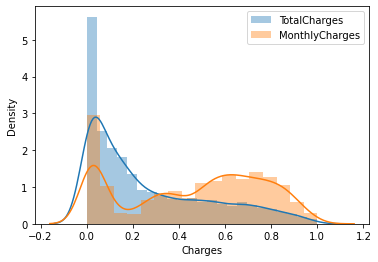

In [76]:
sns.distplot((X_train["TotalCharges"]-X_train["TotalCharges"].min())/(X_train["TotalCharges"].max()-X_train["TotalCharges"].min()), label="TotalCharges")
sns.distplot((X_train["MonthlyCharges"]-X_train["MonthlyCharges"].min())/(X_train["MonthlyCharges"].max()-X_train["MonthlyCharges"].min()), label="MonthlyCharges")
plt.xlabel("Charges")
plt.legend()

Les deux variables ne suivent pas la même distriution et aucune ne semble suivre une loi normale.
Car si par exemple la variable TotalCharges suivait une loi normale l'imputer par la moyenne serait une bonne strategie.

Ainsi à priori nous ne savons pas comment la variable **TotalCharges** est calculée; ce manque d'information rend la tâche de gestion de donnée manquante relativement difficile.

In [77]:
X_train[X_train["TotalCharges"].isna()][["tenure", "TotalCharges", "MonthlyCharges"]]

,tenure,TotalCharges,MonthlyCharges
customerID,,,
2775-SEFEE,0,NaN,61.90
1371-DWPAZ,0,NaN,56.05
3213-VVOLG,0,NaN,25.35
2923-ARZLG,0,NaN,19.70
7644-OMVMY,0,NaN,19.85
5709-LVOEQ,0,NaN,80.85
3115-CZMZD,0,NaN,20.25
2520-SGTTA,0,NaN,20.00
4472-LVYGI,0,NaN,52.55


In [78]:
y_train[X_train["TotalCharges"].isna()]

,Churn
customerID,
2775-SEFEE,No
1371-DWPAZ,No
3213-VVOLG,No
2923-ARZLG,No
7644-OMVMY,No
5709-LVOEQ,No
3115-CZMZD,No
2520-SGTTA,No
4472-LVYGI,No


On remarque que les clients dont la charge totale est manquante sont des clients nouveaux, leur ancienneté est moins de 1 mois et que aucun de ces clients n'a resilié son contrat ce qui est tout à fait logique.

Nombre de clients où leur charges totale est égale à leur ancieneté(en mois) mutiplier par leur charge mensuelle. 

In [79]:
(X_train["MonthlyCharges"]*X_train["tenure"]==X_train["TotalCharges"]).sum()/X_train.shape[0]

0.08466453674121406

Il ya 8% des clients qui respect cette égalité.

In [80]:
X_train[X_train["MonthlyCharges"]*X_train["tenure"]==X_train["TotalCharges"]]["tenure"].value_counts(normalize=True)

1     0.997904
16    0.002096
Name: tenure, dtype: float64

Parmi ces 8% de clients 99% ont une ancieneté de 1mois. Après toute cette analyse nous definissons une strategie qui serait de simplement remplacer les valeurs manquantes de la charge totale par les valeurs de la charge mensuelle.

In [81]:

def impute(data):
    """
    Fonction qui remplace les NAN de TotalCharges par le MonthlyCharges correspondant
    
    Parameters
    ----------
    data: pd.DataFrame 
    Returns
    ---------
    data: pd.DataFrame
    """
    idx = data[data["TotalCharges"].isna()].index
    data.loc[idx,"TotalCharges"] = data.loc[idx,"MonthlyCharges"]
    return data

In [82]:

X_train = impute(X_train)

In [83]:
#X_train = convert_tenure(X_train)

### Analyse de du label

In [84]:
def countplot_ratio(x,data,hue=None,ax=None):
    ax=sns.countplot(x,data=data, hue=hue, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=10)
    ax.set_title(x + " Distributions")
    total = float(len(y_train))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2, height/2,
                '{:.2f}%'.format((height/total)*100),fontsize=12, weight = 'bold',ha="center") 

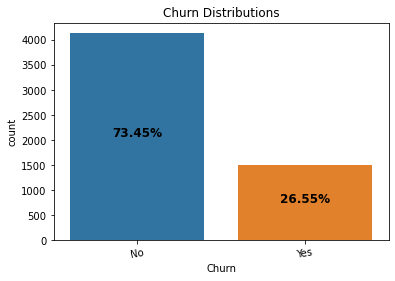

In [85]:
countplot_ratio("Churn", y_train)

La proportion des clients qui ont résilié est moins élévée que ceux qui n'ont pas résilié, nous somme en face d'un problème de classification où les classes sont disproportionnelles. Donc un classifier qui predit tout le temps la classe majoritaire aurait un **Accuracy** (précision) élévée alors; Ainsi pour notre projets, nous allons utiliser la métrique **ROC** pour mesurer la performence de nos classifiers. 

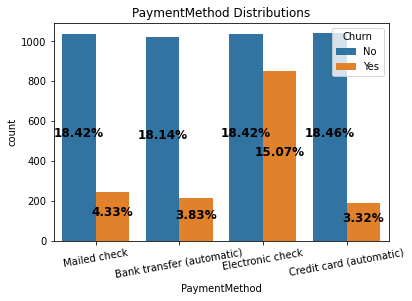

In [86]:
countplot_ratio("PaymentMethod", hue="Churn", data=X_train.merge(y_train, right_on="customerID", left_index=True))

D'après la figure de la distribution de la variable **PaymentMethod**, on remarque le taux de résiliation des clients qui utilisent le mode de payement electronic ckeck est élévé par rapport aux autres mode de payement.
Ainsi nous allons crée une variable boolenne pour ce mode de payement.

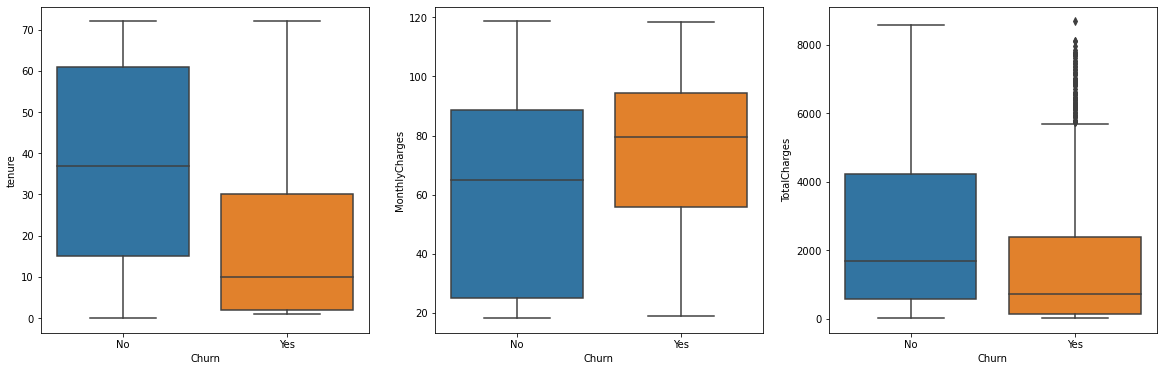

In [87]:
fig, axes = plt.subplots(nrows = 1,ncols = 3,figsize = (20,6))
ax = sns.boxplot(x="Churn", y="tenure", data=X_train.merge(y_train, right_on="customerID", left_index=True), ax=axes[0])
ax = sns.boxplot(x="Churn", y="MonthlyCharges", data=X_train.merge(y_train, right_on="customerID", left_index=True), ax=axes[1])
ax = sns.boxplot(x="Churn",y="TotalCharges",data=X_train.merge(y_train, right_on="customerID", left_index=True),ax=axes[2])

D'après les boxplots on remarque que les distributions des variables **tenure, MonthlyCharges et TotalCharges** ne sont pas identiques en fonction de la categorie du label.
On voit aussi que les clients qui ont une ancieneté de moins de 15mois semblent resiler leur contract ou encore  la moitié des clients qui resilient ont une ancienté de 10mois.

Nous allons créer une variable booleenne qui indiquera si un client a une ancienté de moins de 15mois.

Analysons maintenant les resiliations en fonction du type de contrat

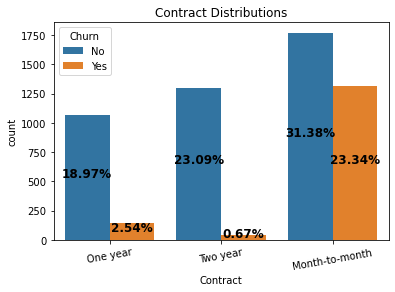

In [88]:
countplot_ratio("Contract", hue="Churn", data=X_train.merge(y_train, right_on="customerID", left_index=True))

On remarque le taux de résiliation change en fonction du type de contrat, les clients avec un contrat mensuelle resilient le plus. Lors du Feature Engineering nous allons crée une variable qui indique si un contrat est mensuelle ou pas.

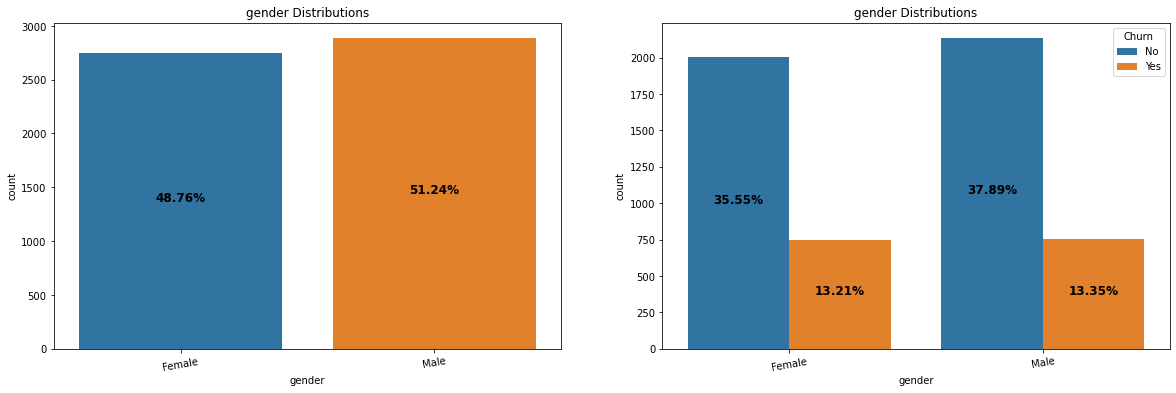

In [89]:
fig, axes = plt.subplots(nrows = 1,ncols = 2,figsize = (20,6))
countplot_ratio(x="gender",data=X_train,hue=None,ax=axes[0])
countplot_ratio(x="gender",data=X_train.merge(y_train, right_on="customerID", left_index=True), hue="Churn",ax=axes[1])

Les proprotions des hommes et des femmes sont presque identiques dans notre base de donnée et le taux de resiliation des hommes et des femmes aussi.

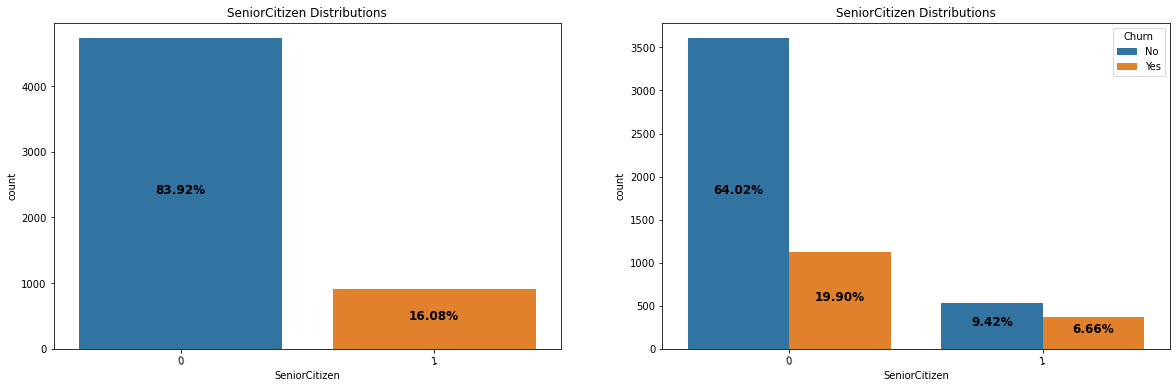

In [90]:
fig, axes = plt.subplots(nrows = 1,ncols = 2,figsize = (20,6))
countplot_ratio(x="SeniorCitizen",data=X_train,hue=None,ax=axes[0])
countplot_ratio(x="SeniorCitizen",data=X_train.merge(y_train, right_on="customerID", left_index=True), hue="Churn",ax=axes[1])

D'apres la figure, 83.92 % des clients sont des jeuness, le taux de resiliation des jeunes est plus élévé.

### Feature Engineering 
D'après nos analyses nous allons creer de nouvelles variables qui sont:
- ElectronicCheck: bool qui indique si mode de payement est ElectronicCheck
- tenure_less_th_15: bool qui indique si un client a une ancieneté de moins de 15mois
- MonthtoMonth: bool qui indique si le type du contract d'un client est mensuelle
- Nb_service: Varibles qui compte le nombre total de services aux un client à souscrit 

#### Remarque:
- Si on fait du OneHotEncoding après les variabls **MonthtoMonth** et **ElectronicCheck** vont exister en doublons dans ce cas nous allons les supprimer

In [91]:
def drop_doub_var(data):
    """
    Fonction qui supprime les variables qui existe en doublons
    """
    return data.drop(["ElectronicCheck", "MonthtoMonth"], axis=True)

In [92]:

def feature_eng(data: pd.DataFrame) ->pd.DataFrame:
    """Fontion qui cree 4 nouvelles variables
    """
    data.loc[:,"ElectronicCheck"] = data.loc[:,"PaymentMethod"]=="Electronic check"
    data.loc[:,"tenure_less_th_15"] = data.loc[:,"tenure"]<=15
    data.loc[:,"MonthtoMonth"] = data.loc[:, "Contract"]=="Month-to-month"
    data.loc[:,"Nb_service"] = (data[["OnlineSecurity","OnlineBackup", "DeviceProtection",
                                        "TechSupport","StreamingTV", "StreamingMovies"]]=='Yes').sum(axis=1)
    return data

In [93]:
X_train = feature_eng(X_train)
data.head(6)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes


### Separation des variables numeriques et catégorielles

In [94]:
def split_cat_num(data):
    """
    Fonction qui separe les variables categrorielle d'avec les numerique
    
    Parameters
    ----------
    data: pd.DataFrame 
    
    Returns
    ---------
    cat: pd.DataFrame
    num: pd.DataFrame
    """
    cat = data.select_dtypes(['object', int, bool])
    num = data.select_dtypes([float])
    #num.loc[num.index, "tenure"] = data.loc[num.index, "tenure"]
    return cat, num

X_train_cat, X_train_num = split_cat_num(X_train)

In [97]:
X_train_num.isna().sum()
#X_train.isna().sum()

MonthlyCharges    0
TotalCharges      0
dtype: int64

In [98]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
#one_hot = OneHotEncoder(handle_unknown='ignore')

### Encodage des variables categorielles:


Nous allons maintenant encoder nos variables, il y a plusieurs manières d'encoder les variables qualitatives:
- Nous allons dans un premier temps faire du one_hot_encoding qui ne prend pas en compte la notion d'ordre

Premierement commençons par separer nos variables qualitatives en deux: binaire et non binaire 


In [99]:

def split_cat_feat(data: pd.DataFrame) ->pd.DataFrame :
    """Separation des variables qualitatives en deux: binaire et non binaire
    """
    binary_feat = []
    for col in data.columns:
        if data[col].unique().shape[0]==2:
            binary_feat.append(col)
    other_cat_feat = data.columns.drop(binary_feat)
    return data[binary_feat], data[other_cat_feat]

In [100]:
bin_feat, no_bin_feat = split_cat_feat(X_train_cat)

In [101]:
def binaire_encoding_fit(data: pd.DataFrame) -> [pd.DataFrame, OrdinalEncoder]:
    """
    fonction qui entraine le OrdinalEncoder
    """
    ord_enc = OrdinalEncoder()
    ord_enc.fit(data)
    
    return ord_enc

binaire_encoder = binaire_encoding_fit(bin_feat)

In [102]:
def binaire_encoding_transfrom(data, encoder):
    """Fonction qui transforme les données en utilisant le ordinalendoder
    """
    vals = encoder.transform(data)
    col = data.columns
    return pd.DataFrame(data=vals, columns=col, index=data.index)

bin_feat_encoded = binaire_encoding_transfrom(bin_feat, binaire_encoder)

On utilise OrdinalEncoder pour encoder les variables binaire en 0/1

In [103]:
def one_hot_encoding_fit(data: pd.DataFrame):
    """
    Fonction qui fait du OneHotEncoder
    """
    one_hot_enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    one_hot_enc.fit(data)
    return one_hot_enc

one_hot_encoder = one_hot_encoding_fit(no_bin_feat)

In [104]:

def one_hot_encoding_transform(data: pd.DataFrame, encoder):
    """
    Fonction qui fait du OneHotEncoder
    """
    vals = encoder.transform(data)
    cols = []
    for i, col in enumerate(data.columns):
        for unique in encoder.categories_[i]:
            cols.append(f"{col}_{unique}")
    df = pd.DataFrame(data = np.hstack((data.values, vals)), columns = list(data.columns) + cols, index=data.index)
    return df.drop(data.columns, axis=1).astype(int)

In [105]:
no_bin_feat_encoded = one_hot_encoding_transform(no_bin_feat, one_hot_encoder)

### Normalisation

Nous allons normaliser nos variables quantitatives pour qu'elles soivent dans la même échelle.

La raison de cette normalisation est que, dans certains algorithmes, les fonctions côuts ne fonctionneront pas correctement sans normalisation. Par exemple, de nombreux classifiers calculent la distance entre deux points par la distance euclidienne. Si l'une des variables prend des grandes valeurs, la distance sera régie par cette variable particulière.

Une autre raison est aussi que la descente de gradient converge beaucoup plus rapidement sur les données normalisées

In [106]:
from sklearn.preprocessing import MinMaxScaler

def scaling_num_feat_fit(data):
    """Fonction qui entaine le minmaxscaler
    """
    scaler = MinMaxScaler()
    scaler.fit(data)
    return scaler
min_max_scaler = scaling_num_feat_fit(X_train_num)

In [107]:
def scaling_num_feat_transform(data, encoder):
    """Fonction qui transforme les donnée en utilisant le minmaxscaler
    """
    vals = encoder.transform(data)
    col = data.columns
    return pd.DataFrame(data=vals, columns=col, index=data.index)
num_feat_transformed = scaling_num_feat_transform(X_train_num, min_max_scaler)

Nous allons maintenant concatener nos trois tables

In [108]:
def creat_mater_table(bin_data, no_bin_data, num_data):
    df = bin_data.merge(no_bin_data, right_on="customerID", left_index=True)
    df = df.merge(num_data, right_on="customerID", left_index=True)
    return df
master_table = creat_mater_table(bin_feat_encoded, no_bin_feat_encoded, num_feat_transformed)

In [109]:
master_table.head()

,gender,Partner,Dependents,PhoneService,PaperlessBilling,ElectronicCheck,tenure_less_th_15,MonthtoMonth,MultipleLines_No,MultipleLines_No phone service,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MonthlyCharges,TotalCharges
customerID,,,,,,,,,,,,,,,,,,,,,
4223-BKEOR,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0,...,1,0,1,0,0,0,0,1,0.464375,0.152089
6035-RIIOM,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0,...,1,0,0,1,1,0,0,0,0.786746,0.589736
3797-VTIDR,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0,1,...,0,1,0,0,0,0,1,0,0.051819,0.000537
2568-BRGYX,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1,0,...,0,1,0,0,0,0,1,0,0.517688,0.025288
2775-SEFEE,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0,0,...,0,0,0,1,1,0,0,0,0.434978,0.004973


Matrix de correlation:
Nous allons voir comment nos variables sont correlées afin de faire une première selection de variable

Tout d'abord encodons notre label (yes, non) -> (1, 0)

In [110]:
from sklearn.preprocessing import LabelEncoder
def label_encoding(data: pd.DataFrame) -> [pd.DataFrame, OrdinalEncoder]:
    """
    fonction qui fait du OrdinalEncoder
    """
    df = data.copy()
    ord_enc = LabelEncoder()
    vals = ord_enc.fit_transform(df["Churn"])
    df.loc[:,"Churn"] = vals
    return df
y_train = label_encoding(y_train)
#threshold

In [111]:
y_train.head()

,Churn
customerID,
4223-BKEOR,0
6035-RIIOM,0
3797-VTIDR,1
2568-BRGYX,1
2775-SEFEE,0


Maintenant comme nous l'avons indiqué plus haut, nous allons supprimer les variables en doublons.

In [112]:
master_table = drop_doub_var(master_table)

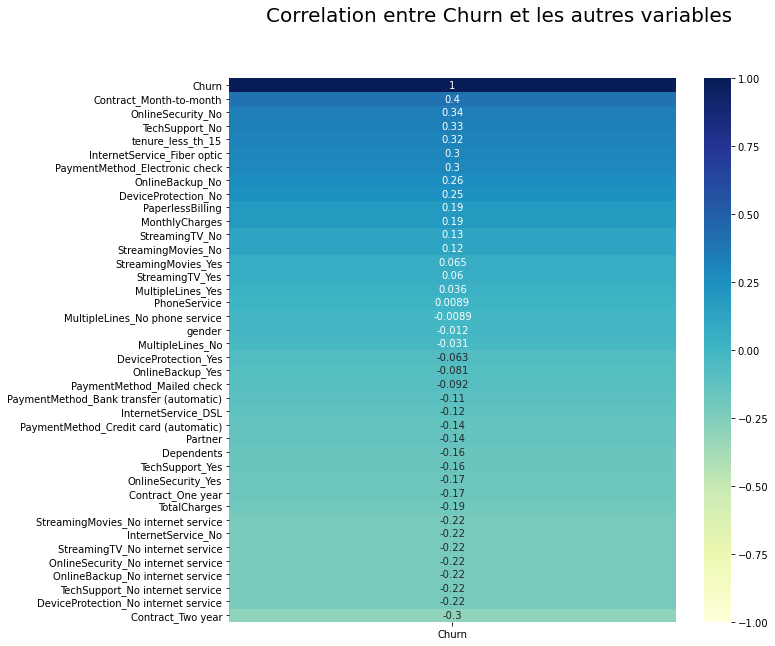

In [113]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Correlation entre Churn et les autres variables',fontsize=20)
ax=sns.heatmap(master_table.merge(y_train, right_on="customerID", left_index=True).corr()[["Churn"]].sort_values("Churn"),vmax=1, vmin=-1, cmap="YlGnBu", annot=True, ax=ax);
ax.invert_yaxis()


Nous allons maintenant definir un seuil pour selectionner les variables dont leur correlation va depasser

In [114]:
def select_feat_by_corr(X, y, threshold=0.09):
    data = X.merge(y, right_on="customerID", left_index=True)
    churn_corr = data.corr()[["Churn"]].sort_values("Churn")
    feat_to_drop=list(churn_corr[(churn_corr["Churn"]< threshold)& (churn_corr["Churn"]>-threshold)].index)
    return feat_to_drop
feat_to_drop = select_feat_by_corr(master_table, y_train)

In [115]:
nb_feat_to_drop = len(feat_to_drop)
feat_to_drop

['OnlineBackup_Yes',
 'DeviceProtection_Yes',
 'MultipleLines_No',
 'gender',
 'MultipleLines_No phone service',
 'PhoneService',
 'MultipleLines_Yes',
 'StreamingTV_Yes',
 'StreamingMovies_Yes']

Nous allons supprimer ces 13 variables de master_table

In [116]:
new_master_table = master_table.drop(feat_to_drop, axis=1)

In [117]:
new_master_table.head()

,Partner,Dependents,PaperlessBilling,tenure_less_th_15,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,...,StreamingMovies_No internet service,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MonthlyCharges,TotalCharges
customerID,,,,,,,,,,,,,,,,,,,,,
4223-BKEOR,0.0,1.0,0.0,0.0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0.464375,0.152089
6035-RIIOM,0.0,0.0,1.0,0.0,0,1,0,1,0,0,...,0,0,0,1,1,0,0,0,0.786746,0.589736
3797-VTIDR,1.0,0.0,1.0,1.0,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0.051819,0.000537
2568-BRGYX,0.0,0.0,1.0,1.0,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0,0.517688,0.025288
2775-SEFEE,0.0,1.0,1.0,1.0,1,0,0,0,0,1,...,0,0,0,1,1,0,0,0,0.434978,0.004973


In [118]:
#min_max_scaler

Nos données sont analysées, netoyer et encoder, c'est le moment d'entraîner un classifier

### Pipeline inference

Avant cela nous allons definir un **pipeline** qui appliquera toutes les modifications et transformations sur notre base de validation

In [119]:
def pipeline(X, binaire_encoder, one_hot_encoder, min_max_scaler, colunms_to_drop):
    """ 
    pipeline qui applique toutes les modifications et transformations sur X
    
    """
    X = conver_tot_char_to_num(X)
    X = impute(X)
    X = feature_eng(X)
    X_cat, X_num = split_cat_num(X)
    bin_feat, no_bin_feat = split_cat_feat(X_cat)
    bin_feat_encoded = binaire_encoding_transfrom(bin_feat, binaire_encoder)
    #binaire_encoder.transform(bin_feat)
    no_bin_feat_encoded = one_hot_encoding_transform(no_bin_feat, one_hot_encoder)
    #one_hot_encoder.transform(no_bin_feat)
    num_feat_scaled = scaling_num_feat_transform(X_num, min_max_scaler)
    #min_max_scaler.transform(X_num)
    master_table = creat_mater_table(bin_feat_encoded, no_bin_feat_encoded, num_feat_scaled)
    master_table = drop_doub_var(master_table)
    new_master_table = master_table.drop(colunms_to_drop, axis=1)
    return new_master_table


In [120]:
val = pipeline(X_val, binaire_encoder, one_hot_encoder, min_max_scaler, feat_to_drop)

In [121]:
y_val.head()

,Churn
customerID,
1024-GUALD,Yes
0484-JPBRU,No
3620-EHIMZ,No
6910-HADCM,Yes
8587-XYZSF,No


In [122]:
y_ = label_encoding(y_val)

In [123]:
y_.head()

,Churn
customerID,
1024-GUALD,1
0484-JPBRU,0
3620-EHIMZ,0
6910-HADCM,1
8587-XYZSF,0


### Entrainement

- Nous allons tester plusieurs algo de classification

Nous deffinissons la fonction **evaluation** pour evaluer nos algos

In [124]:
def evaluation(model, X_train, y_train, X_test):
    
    model.fit(X_train, y_train)
    #ypred = model.predict(X_test)
    #print(classification_report(y_val, ypred))
    #print(pd.crosstab(y_val, ypred, rownames=['Actual'], colnames=['Predicted'], margins=True))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=3, scoring='f1_micro',
                                               train_sizes=np.linspace(0.1, 1, 10),
                                               n_jobs =-1
                                               )
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score' )
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

In [10]:
import time
b = time.time()
time.sleep(3)
e = time.time()
e-b

3.007378578186035

In [29]:
def trie_int(L):
    return [i for i in L if isinstance(i, int)]
trie_int([1,3,5,8,'a','g'])           

[1, 3, 5, 8]

In [28]:
def trie_int(L):
    LL = []
    [for i in L LL.append(i)]
    return LL
trie_int([1,3,5,8,'a','g']) 

SyntaxError: invalid syntax (<ipython-input-28-369feea0d618>, line 3)

In [ ]:
def evaluation1(model, X_train, y_train):
    
    model.fit(X_train, y_train)
    #ypred = model.predict(X_test)
    #print(classification_report(y_val, ypred))
    #print(pd.crosstab(y_val, ypred, rownames=['Actual'], colnames=['Predicted'], margins=True))
    b = time.time()
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=3, scoring='auc',
                                               train_sizes=np.linspace(0.1, 1, 10),
                                               n_jobs =-1
                                               )
    e = time.time()
    return train_score.mean(), train_score.std(), val_score.mean(), val_score.std(), e-b
    
    
    socres_train_mean = []
    socres_train_std = []
    socres_val_mean = []
    socres_val_std = []
    scores_train_mean.append(train_score.mean())
    scores_std.append(t)
    scores["means"] = 
    #plt.figure(figsize=(12, 8))
    #plt.plot(N, train_score.mean(axis=1), label='train score' )
    #plt.plot(N, val_score.mean(axis=1), label='validation score')
    #plt.legend()

In [54]:
np.savetxt('tmp.txt', l, delimiter=',')

In [53]:
#l = []
l.append((1,2))
l

[(1, 2), (1, 2), (1, 2), (1, 2)]

In [64]:
x = np.loadtxt("tmp.txt")
#a = x.read()
#a = a.split('\n')

ValueError: could not convert string to float: '1.000000000000000000e+00,2.000000000000000000e+00'

In [62]:
a.split(',')

['1.000000000000000000e+00',
 '2.000000000000000000e+00\n1.000000000000000000e+00',
 '2.000000000000000000e+00\n1.000000000000000000e+00',
 '2.000000000000000000e+00\n1.000000000000000000e+00',
 '2.000000000000000000e+00\n']

In [58]:
a = [float(i) for i in a]

ValueError: could not convert string to float: '1.000000000000000000e+00,2.000000000000000000e+00'

In [59]:
a

['1.000000000000000000e+00,2.000000000000000000e+00',
 '1.000000000000000000e+00,2.000000000000000000e+00',
 '1.000000000000000000e+00,2.000000000000000000e+00',
 '1.000000000000000000e+00,2.000000000000000000e+00',
 '']

In [43]:
a.split('\n')

['1.000000000000000000e+00',
 '2.000000000000000000e+00',
 '3.000000000000000000e+00',
 '']

On va selectionner le meilleur modele, que nous allons éventuellement essayer d'ameliorer

- XGBClassifier

In [130]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import f1_score, confusion_matrix, classification_report
#from yellowbrick.model_selection import feature_importances
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score

In [129]:
#pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [138]:
from xgboost import  XGBClassifier
xgb_clf = XGBClassifier(eval_metric='auc', seed=32)
xgb_clf.fit(new_master_table, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=32, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=32, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [139]:
print("AUC XGB = {}".format(roc_auc_score(y_, xgb_clf.predict_proba(val)[:, 1])))

AUC XGB = 0.8366565052221889


XGBClassifier a un bon score sur les données de validaton, Nous allons voir si la variance de notre model est grande

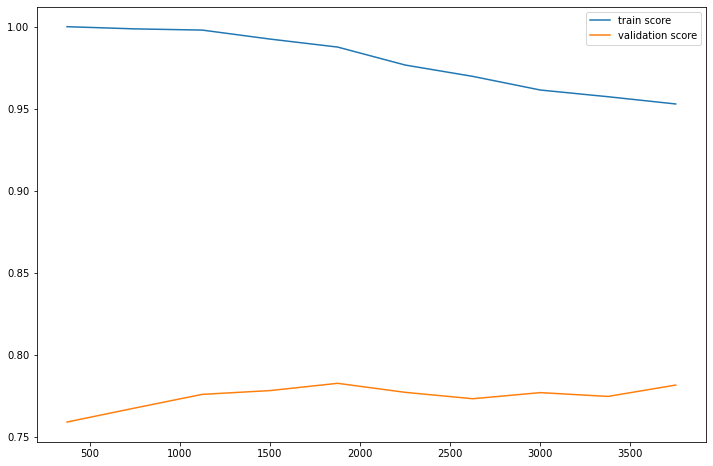

In [140]:
evaluation(xgb_clf, new_master_table, y_train, val)

D'apres la figure on remarque qu'en faisant une cross validation (cv=3), l'evolution de la courbe d'apprentissage montre que la variation du score du modele est realtivement grande entre l'entrainement et la validation.
Vu la tendance croissante de la courbe de validation, on peut esperer ameliorer le score en acquérant plus de données.

- Visualisation l'importance des variables

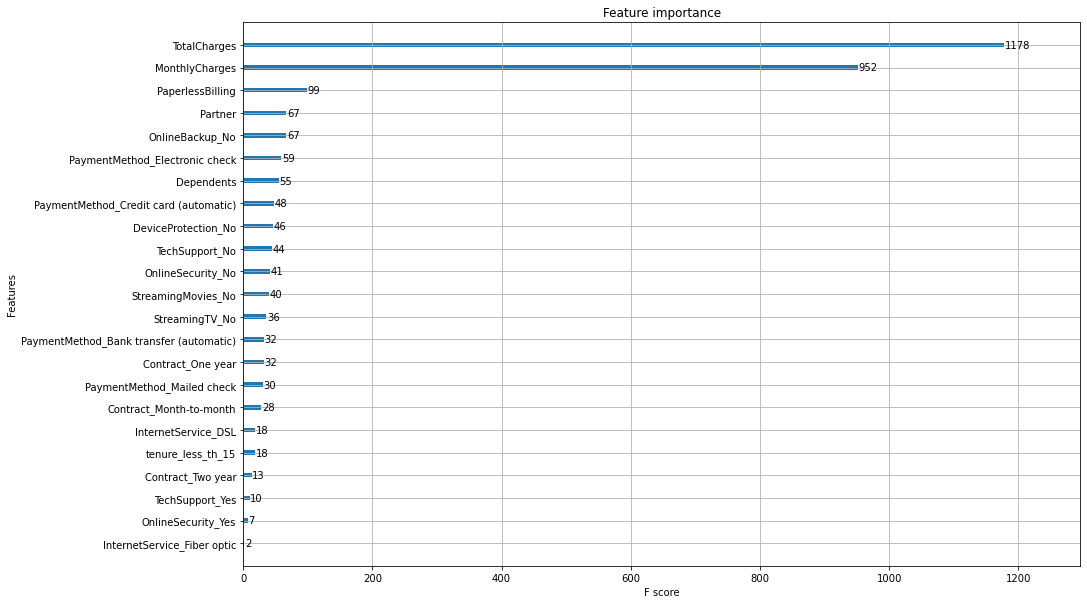

In [141]:
fig, ax = plt.subplots(figsize=(15,10))
from xgboost import plot_importance
plot_importance(xgb_clf,ax=ax)
plt.show()

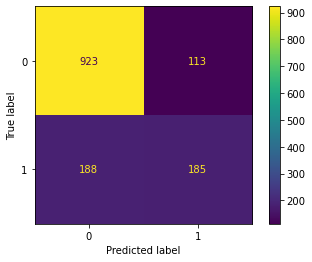

In [142]:
plot_confusion_matrix(xgb_clf, val, y_)  
plt.show() 
#sns.heatmap(y, annot=True)

D'après la matrice de confusion on remarque que la proportion de **Faux Negatives** est plus élévée que celles des **Faux positives**.
Dans notre cas il serait mieux que la proportion de faux positives soit plus élévée. C'est à dire de predire qu'un client va resilier même si c'est pas le cas que de predire le contraire alors que le client va resilier.

- Erreurs: Nous allons recuperer les clients qui n'ont pas été bien classé lors de la prediction du modele XGboost

In [143]:
miss_class_xgb = X_val[xgb_clf.predict(val)!=y_["Churn"].values]
miss_class_xgb

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,,,,,,,,,,,,,
6818-WOBHJ,Female,1,Yes,No,68,Yes,Yes,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,Yes,Bank transfer (automatic),89.60,6127.6
4853-RULSV,Male,0,No,No,70,Yes,Yes,Fiber optic,Yes,No,No,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),104.00,7250.15
5766-ZJYBB,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.40,19.4
5914-DVBWJ,Female,1,No,No,18,Yes,Yes,Fiber optic,No,Yes,No,Yes,No,No,Month-to-month,Yes,Electronic check,85.45,1505.85
9530-EHPOH,Male,0,No,No,11,Yes,Yes,DSL,No,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.75,608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0946-CLJTI,Male,1,Yes,No,58,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.70,5812.6
1029-QFBEN,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.55,19.55
1197-BVMVG,Female,1,No,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,74.45,294.45


- LogisticRegression

In [144]:
from sklearn.linear_model import LogisticRegression
logis_Reg_clf = LogisticRegression(random_state=32)
logis_Reg_clf.fit(new_master_table, y_train)

LogisticRegression(random_state=32)

In [145]:
print("AUC LogisticRegression = {}".format(roc_auc_score(y_, logis_Reg_clf.predict_proba(val)[:, 1])))


AUC LogisticRegression = 0.8579864813108781


La LogisticRegression fait mieux que XGBClassifier

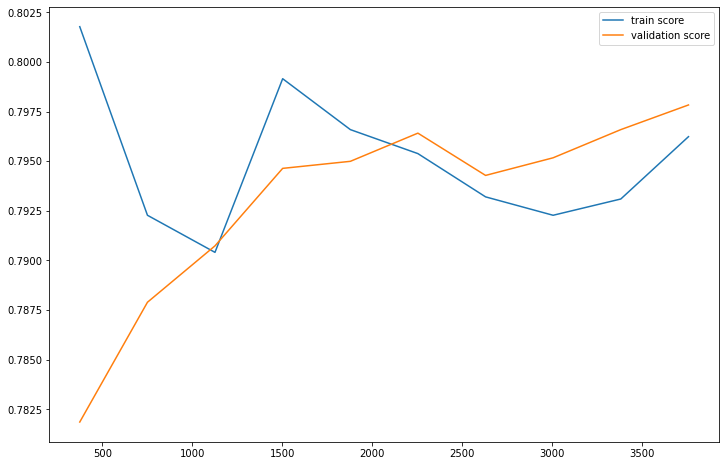

In [146]:
evaluation(logis_Reg_clf, new_master_table, y_train, val)

La variance de la LogisticRegression est quasiment nulle, elle ne semble pas faire du surapprentissage

In [147]:
feature_importances(logis_Reg_clf, new_master_table, y_train)

NameError: name 'feature_importances' is not defined

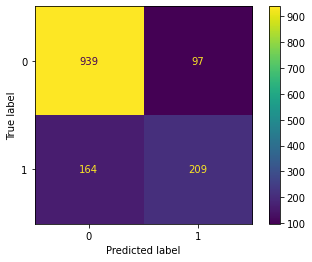

In [148]:
plot_confusion_matrix(logis_Reg_clf, val, y_)  
plt.show() 
#sns.heatmap(y, annot=True)

Globalement les variables que nous avons créer lors du feature  Engineering ont une contribution significative pour  **LogisticRegression**

- Erreur de classification  LogisticRegression: Nous allons recuperer les clients mal classé lors de la prediction

In [149]:
miss_class_logi = X_val[logis_Reg_clf.predict(val)!=y_["Churn"].values]
miss_class_logi

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,,,,,,,,,,,,,
6818-WOBHJ,Female,1,Yes,No,68,Yes,Yes,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,Yes,Bank transfer (automatic),89.60,6127.6
4853-RULSV,Male,0,No,No,70,Yes,Yes,Fiber optic,Yes,No,No,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),104.00,7250.15
5766-ZJYBB,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.40,19.4
5914-DVBWJ,Female,1,No,No,18,Yes,Yes,Fiber optic,No,Yes,No,Yes,No,No,Month-to-month,Yes,Electronic check,85.45,1505.85
9530-EHPOH,Male,0,No,No,11,Yes,Yes,DSL,No,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.75,608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7245-NIIWQ,Female,0,No,No,3,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,69.85,199.85
4853-OITSN,Male,0,Yes,No,5,Yes,Yes,Fiber optic,Yes,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,89.15,413.25
1197-BVMVG,Female,1,No,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,74.45,294.45


**comparaison**:
Nous allons indentifiers les clients dont les deux modeles ont mal classifié

In [150]:
miss_class_logi.reset_index(inplace=True)
#pd.Series(miss_class_logi.index).isnin(miss_class_xgb.index)
#customerID
miss_class_logi.isin({'customerID': miss_class_xgb.index})["customerID"].sum()

187

Il y a 183 clients qui ont été mal classifié par les deux modeles: Nous pourrons envisager de poursuivre nos analyse afin de pouvoir identifier la particularité de ces 183 clients qui fait defaut

 - KNeighborsClassifier

In [151]:
from sklearn.neighbors import KNeighborsClassifier
Knn_clf = KNeighborsClassifier(n_neighbors=10)
Knn_clf.fit(new_master_table, y_train)
roc_auc_score(y_, Knn_clf.predict_proba(val)[:, 1])

0.8233306075129132

In [156]:
!python monitoring.py xgb_clf, logis_Reg_clf, Knn_clf

Monitoring starting below...
Battery capacity set to logis_Reg_clf,
Writing data into file xgb_clf,
Monitoring starting below...
Battery capacity set to logis_Reg_clf,
Writing data into file xgb_clf,


Process p1:
Traceback (most recent call last):
  File "C:\Users\kane_\Anaconda3\lib\multiprocessing\process.py", line 315, in _bootstrap
    self.run()
  File "C:\Users\kane_\Anaconda3\lib\multiprocessing\process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\kane_\Downloads\monitoring.py", line 52, in monitore
    BT_Wh = float(sys.argv[2])#condition of battery in Wh, given by command inxi -B (ubuntu or mac os)
ValueError: could not convert string to float: 'logis_Reg_clf,'


Le KNN étant un modèle non parametrique.
Puisqu'on est en grande dimension nous avons jugé qu'on ne peut pas se fier à la performance de ce modele qui est basé sur le calcule des distances entres les observations.

- RandomForestClassifier

In [338]:
from sklearn.ensemble import RandomForestClassifier
rand_clf = RandomForestClassifier(max_depth=10, random_state=0)
rand_clf.fit(new_master_table, y_)
roc_auc_score(y_, rand_clf.predict_proba(val)[:, 1])

0.858020122765431

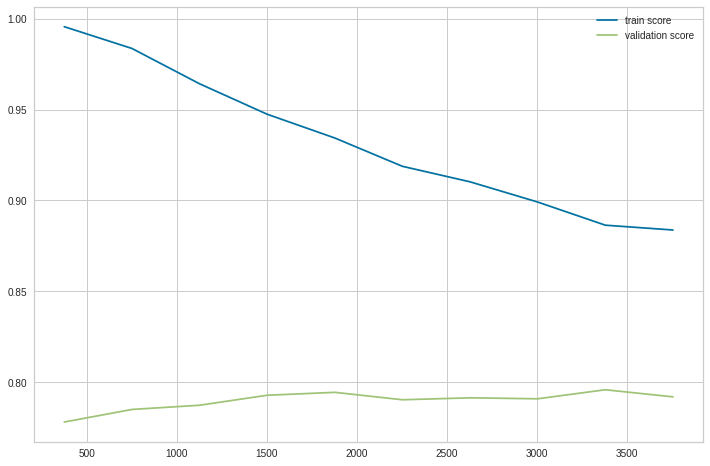

In [339]:
evaluation(rand_clf, new_master_table, y_train, val)

- Reseaux de neurones

In [168]:
#pip install tensorflow 

In [167]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

In [169]:
model = Sequential()
model.add(Dense(units=30,activation='relu'))
model.add(Dense(units=15,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

In [65]:
s = 'sortie.txt'
s.split('.txt')

['sortie', '']

In [171]:
predictions = (model.predict(val) > 0.5).astype("int32")

In [ ]:
from sklearn.neural_network import MLPClassifier
percep = MLPClassifier(random_state=1, max_iter=3000).fit(new_master_table, y_train)

In [547]:
roc_auc_score(y_, percep.predict_proba(val)[:, 1])

0.8200777376380591

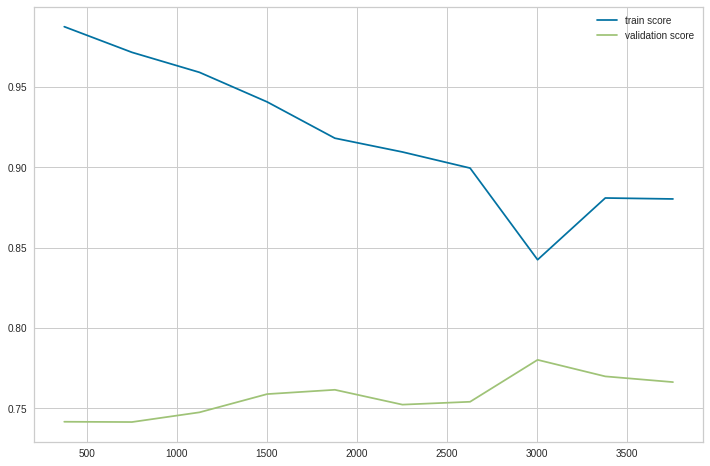

In [548]:
evaluation(percep, new_master_table, y_train, val)

Le reseaux de neuronnes fait mieux que l'algo KNN

Nous voyons sur la figures par ordre croissant les variables qui impactent notre model

Type d'encodage de la variable **tenure** qu'on a voulu appliqué au debut

In [158]:
y_pred_logi = logis_Reg_clf.predict(val)
y_pred_logi

array([1, 0, 0, ..., 0, 0, 0])

### Test d'hypothèse pour évaluer l'effet de la campagne

Comme enumerer au debut du projet, l'objectif n'est pas seulement de prédire la proba d'attrition de clients mais également d'effectuer une campagne de retention. 
Ainsi afin de mesurer l'efficacité de la campagne de retension nous allons faire le tes **A/B**. 
Le test A/B est un moyen de comparer deux versions d'une même variable.
Dans notre cas nous allons subdiviser en deux groupes: groupe de controle(dont la campagne ne va pas cibler) et le groupe de traitement(qui va être cibler par la campagne) les clients dont notre algo a predit qu'ils vont resilier le prochain mois.
L'hypothèse nulle est: la proportion des clients qui ont reellement resilié est identique dans les deux groupes.

Afin d'obtenir des résultats significatifs, nous voulons que notre test ait une puissance statistique d'au moins 0.8 ; la taille des groupes a une influence sur la puissance statistique. Le niveau du test est fixé à 0.05

Afin d'avoir les bonnes proportions nous allons calculer la tailles des groupes avec les formules suivantes: 

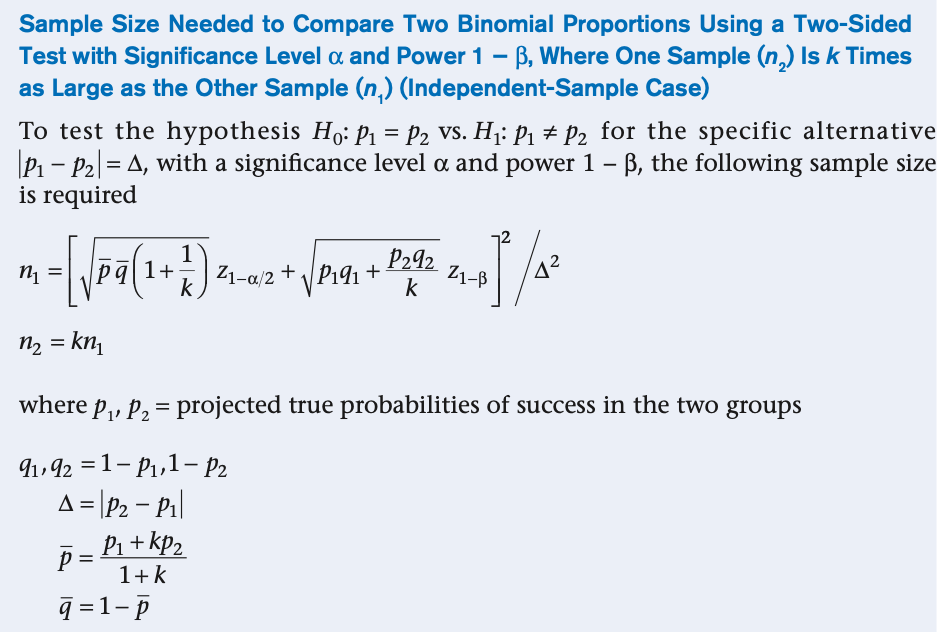

In [369]:
from IPython.display import Image
Image(filename='a_b_test.png')

In [408]:
import scipy.stats as scs
def traitement_control_group_size(k, pt, pc, alpha=0.05, beta=0.2):
    standard_norm = scs.norm(0, 1)
    z_alpha = standard_norm.ppf(1 - alpha/2)
    z_beta = standard_norm.ppf(1 - beta)
    qc, qt = 1 - pc, 1 - pt
    delta = abs(pc - pt)
    p_bar = (pc + k*pt)/(1 +k)
    q_bar = 1-p_bar
    A = z_alpha*np.sqrt(p_bar*q_bar*(1+ 1/k))
    B = z_beta*np.sqrt(pt*qt + (pc*qc/k))
    nt = (A + B)**2/delta**2
    return int(k*nt), int(nt)
#traitement_control_group_size(k=1, pt=0.14, pc=0.217, alpha=0.05, beta=0.2)

In [450]:
resil_prop = y_pred_logi.mean()
resil_prop

0.21717530163236337

D'après le classifier **LogisticRegression** environs 21% des 1409 clients dans la base de test soit 306 clients vont resilier le prochain mois

Au vue de la petite taille de notre base de test, en Supposant que la campagne va reduire de 13% le taux de resiliation, nous allons calculer la proportion de chaque groupe pour evaluer l'effet de la campagne. 

In [445]:
traitement_control_group_size(k=1, pt=resil_prop-0.13, pc=resil_prop, alpha=0.05, beta=0.2)

(118, 118)

Avec ces informations il faut qu'on ait 118 clients choisit aleatoirement dans la base de test pour construire nos deux groupes

In [521]:
n = y_pred_logi.shape[0]
size = 118
import random
ind_resil = val.index[y_pred_logi==1]
control_ind = random.sample(ind_resil.to_list(), size)
not_choosed_ind = ind_resil[~ind_resil.isin(a)].to_list()
traitement_ind = random.sample(not_choosed_ind, size)

In [535]:
y_control_group = val.loc[control_ind, :]
traitement_group = val.loc[traitement_ind, :]

In [544]:
from scipy.stats import ttest_ind
y_control = y_.loc[control_ind, :]
y_traitement = y_.loc[traitement_ind, :]
mean_control = np.mean(y_control["Churn"])
mean_traitement = np.mean(y_traitement["Churn"])
print("moyenne du groupe de controle: ", mean_control)
print("moyenne du groupe de traitement: ",mean_traitement)

ttest,pval = ttest_ind(y_control, y_traitement)
print("p-value",pval)
if pval <0.05:
    print("Nous rejetons l'hypothèse nulle")
else:
    print("Nous acceptons l'hypothèse nulle")

moyenne du groupe de controle:  0.7288135593220338
moyenne du groupe de traitement:  0.6949152542372882
p-value [0.56727645]
Nous acceptons l'hypothèse nulle


### Conclusion 

Ce projet a été très enrichissant et nous a permit de nous confronter aux données réelles issues d'une entreprise de télécommunication. Cette problematique est commun à toutes les entreprises qui proposent des abonnements à ses clients.


Pour faire la prediciton des probas de resiliation dans un mois des clients nous avons essayer plusieurs modeles de machines learning et un reseau de neuronne.

Etant donnée que nous avons fait un compromis entre l'explicabilité et la complexité de modèle.
Notre modele de regession logistique n'a pas été combiner avec d'autre modeles potientiels pour ameliorer ses performances.

Nous tenons à preciser que nous n'avons fait aucune optimisation d'hyper-paramètres de nos modèles, alors que cela pourrait nettement ameliorer les performances.

Nous avons fait le test de l'efficacité de la campagne de rentention; il s'est avéré qu'elle n'est pas efficace ce qui est normale car aucune campagne n'a été réaliser. Ce test test à été fait pour illustrer le domaine d'application